In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk
matplotlib.style.use('ggplot')

# From Excel training sheets
training_values = pd.read_csv('/Users/noahmitchellward/Desktop/EECS_351/Project/Training_Set_Values.csv')
training_labels = pd.read_csv('/Users/noahmitchellward/Desktop/EECS_351/Project/Training_Set_Labels.csv')

# Get the full training set
train = pd.merge(training_labels, training_values, how='inner', on='id')


In [2]:
# Replacing zero/null construction years with the average of construction year
constrMean = train[train['construction_year'] > 0]['construction_year'].mean()

train2 = train

train2['construction_year'] = train2['construction_year'].replace(np.nan,constrMean)
train2['construction_year'] = train2['construction_year'].replace(0,constrMean)
train2.loc[train2['construction_year'] == np.nan]

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [3]:
train2['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [32]:
# messing around
pd.crosstab(train['district_code'],train['status_group'])

status_group,functional,functional needs repair,non functional
district_code,,,
0,4,2,17
1,6558,1287,4358
2,6203,844,4126
3,4954,699,4345
4,5595,509,2895
5,2479,194,1683
6,2055,232,1787
7,2014,214,1115
8,589,53,401


In [12]:
# Function to delete columns from dataframe. Input matrix of strings as second parameter.
def deleteColumns1(train_values):
    catList = ['extraction_type_group','extraction_type_class','quantity_group','quality_group','recorded_by',
              'num_private','payment_type','waterpoint_type_group','scheme_name','amount_tsh']
    for category in catList:
        train_values = train_values.drop(category,1)
    return train_values

In [14]:
deleteColumns1(train).columns

Index(['id', 'status_group', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type'],
      dtype='object')

In [3]:
# Removing columns that are deemed not useful, incoherent, or have little predictive power

# We can see here that extraction_type is the most specific instance of the extraction method, with
# extraction_type_group is the most general, and extraction_type_class in the middle. We use the most specific case.
print(pd.crosstab(train['extraction_type'],train['extraction_type_group']))

print(pd.crosstab(train['extraction_type'],train['extraction_type_class']))

del train2['extraction_type_group']
del train2['extraction_type_class']

# Next is quantity and quantity_group - they contain the same data, so we delete quantity_group
print(pd.crosstab(train['quantity'],train['quantity_group']))

del train2['quantity_group']


extraction_type_group      afridev  gravity  india mark ii  india mark iii  \
extraction_type                                                              
afridev                       1770        0              0               0   
cemo                             0        0              0               0   
climax                           0        0              0               0   
gravity                          0    26780              0               0   
india mark ii                    0        0           2400               0   
india mark iii                   0        0              0              98   
ksb                              0        0              0               0   
mono                             0        0              0               0   
nira/tanira                      0        0              0               0   
other                            0        0              0               0   
other - mkulima/shinyanga        0        0              0      

In [34]:
# Function to delete columns from dataframe
def deleteColumns(df, catList):
    for category in catList:
        df = df.drop(category,1)
    return df

In [35]:
deleteColumns(train2,['num_private','payment']).columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [40]:
train2.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [3]:
districts = [1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67]

#Read in csv
district_values = training_values.filter(['district_code', 'gps_height','longitude','latitude','population'], axis=1)
district_values = district_values.sort_values(by='district_code')

#Replace zeros/ones with NaNs for correct calculation of means
district_values['gps_height'] = district_values['gps_height'].replace(0, np.nan)
district_values['longitude'] = district_values['longitude'].replace(0, np.nan)
district_values['latitude'] = district_values['latitude'].replace(0, np.nan)
district_values['population'] = district_values['population'].replace(0, np.nan)
district_values['population'] = district_values['population'].replace(1, np.nan)

district_values.to_csv("District Values.csv")

#Calculate means
district_means = district_values.groupby(['district_code']).mean()
#Round the population column
district_means['population'] = district_means['population'].round()
print(district_means)

#Replace zeros/ones with NaNs in original dataframe for correct replacements
training_values['gps_height'] = training_values['gps_height'].replace(0, np.nan)
training_values['longitude'] = training_values['longitude'].replace(0, np.nan)
training_values['latitude'] = training_values['latitude'].replace(0, np.nan)
training_values['population'] = training_values['population'].replace(0, np.nan)
training_values['population'] = training_values['population'].replace(1, np.nan)

j = 1;
for i in districts:
	#Create dictionaries for each district code
	temp_dict = {'gps_height': district_means.iloc[j]['gps_height'], 'longitude': district_means.iloc[j]['longitude'],
				'latitude': district_means.iloc[j]['latitude'], 'population': district_means.iloc[j]['population']}
	#Assign fill values based on dictionary
	training_values.loc[training_values['district_code'] == i, :] = training_values.loc[training_values['district_code'] == i, :].fillna(temp_dict)
	j += 1

#Districts 0 and 80 have NaN means for gps_height and population,
#	so calculate alternate values and fill in appropriately
col_means = district_means.mean()
col_means['population'] = col_means['population'].round()
print(col_means)

dict0 = {'gps_height': col_means['gps_height'], 'longitude': district_means.iloc[0]['longitude'],
				'latitude': district_means.iloc[0]['latitude'], 'population': col_means['population']}

dict80 = {'gps_height': col_means['gps_height'], 'longitude': district_means.iloc[19]['longitude'],
				'latitude': district_means.iloc[19]['latitude'], 'population': col_means['population']}
training_values.loc[training_values['district_code'] == 0, :] = training_values.loc[training_values['district_code'] == 0, :].fillna(dict0)
training_values.loc[training_values['district_code'] == 80, :] = training_values.loc[training_values['district_code'] == 80, :].fillna(dict80)

                gps_height  longitude   latitude  population
district_code                                               
0                      NaN  36.660254  -6.462376         NaN
1               998.432498  35.236521  -4.898312       363.0
2              1154.388257  34.766709  -5.004393       396.0
3               980.406531  34.572040  -6.279798       335.0
4              1262.733170  35.019680  -6.682858       234.0
5              1035.829251  35.359905  -6.370696       268.0
6               768.784663  35.059489  -5.061056       404.0
7              1357.935826  35.320572  -4.668943       241.0
8              1230.076923  34.585217  -3.582127       363.0
13               71.455243  39.186059  -8.774497       360.0
23              135.791096  39.481374 -10.087429       403.0
30             1472.082822  32.290148  -2.856005       425.0
33              374.255149  39.033148 -10.290958       469.0
43              167.371769  38.837396  -7.940416       923.0
53              141.5691

In [4]:
svmCols = pd.concat([training_values['longitude'], train2['latitude']], axis=1)
svmCols = pd.concat([svmCols, training_values['gps_height']], axis=1)

X = svmCols.as_matrix()
X

array([[   34.93809275,    -9.85632177,  1390.        ],
       [   34.6987661 ,    -2.14746569,  1399.        ],
       [   37.46066446,    -3.82132853,   686.        ],
       ..., 
       [   34.01708706,    -8.75043433,  1357.93582589],
       [   35.86131531,    -6.37857327,  1262.73317033],
       [   38.10404822,    -6.74746425,   191.        ]])

In [6]:
from itertools import cycle

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

y = training_labels['status_group']

y


0                     functional
1                     functional
2                     functional
3                 non functional
4                     functional
5                     functional
6                 non functional
7                 non functional
8                 non functional
9                     functional
10                    functional
11                    functional
12                    functional
13                    functional
14                    functional
15                    functional
16                non functional
17                non functional
18       functional needs repair
19                    functional
20                    functional
21                    functional
22       functional needs repair
23                    functional
24                    functional
25       functional needs repair
26                    functional
27                    functional
28                non functional
29                    functional
          

In [7]:
y = label_binarize(y, classes=['functional', 'non functional', 'functional needs repair'])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)
y


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [47]:
# Learn to predict each class against the other, used for ROC curves
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf'))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [12]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC())
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [13]:
score = classifier.score(X_test,y_test)
score

0.49841750841750843

In [57]:
# plotting ROC curves

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


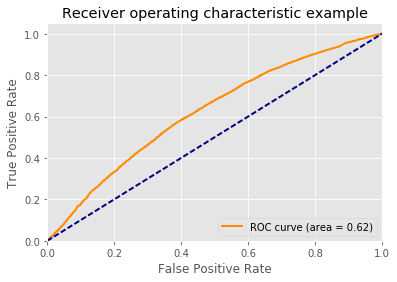

In [60]:
# Actual plotting step
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

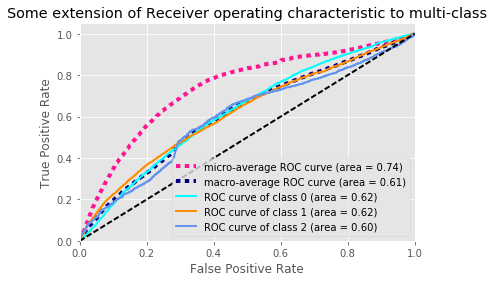

In [61]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

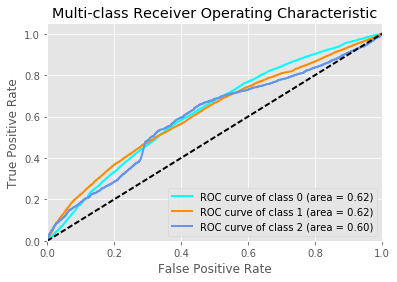

In [63]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
 #        label='micro-average ROC curve (area = {0:0.2f})'
  #             ''.format(roc_auc["micro"]),
   #      color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
 #        label='macro-average ROC curve (area = {0:0.2f})'
  #             ''.format(roc_auc["macro"]),
   #      color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [54]:
y_score.min()

-2.4103197612822527

In [18]:
#DO NOT USE
from sklearn import preprocessing

y = training_labels['status_group']

le = preprocessing.LabelEncoder()
le.fit(y)

y = le.transform(y)
y



array([0, 0, 0, ..., 0, 0, 0])

In [7]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
score = clf.score(X,y)

In [9]:
score

0.65742424242424247

In [20]:
from sklearn import svm

clf = svm.SVC()

clf.set_params(class_weight='balanced')
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
clf.score(X,y)

0.57254208754208757

In [73]:
test_values = pd.read_csv('/Users/noahmitchellward/Desktop/EECS_351/Project/Test_Set_Values.csv')


In [74]:
districts2 = [1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67]

#Read in csv
district_values2 = test_values.filter(['district_code', 'gps_height','longitude','latitude','population'], axis=1)
district_values2 = district_values2.sort_values(by='district_code')

#Replace zeros/ones with NaNs for correct calculation of means
district_values2['gps_height'] = district_values2['gps_height'].replace(0, np.nan)
district_values2['longitude'] = district_values2['longitude'].replace(0, np.nan)
district_values2['latitude'] = district_values2['latitude'].replace(0, np.nan)
district_values2['population'] = district_values2['population'].replace(0, np.nan)
district_values2['population'] = district_values2['population'].replace(1, np.nan)

district_values2.to_csv("District Values.csv")

#Calculate means
district_means2 = district_values2.groupby(['district_code']).mean()
#Round the population column
district_means2['population'] = district_means2['population'].round()
print(district_means2)

#Replace zeros/ones with NaNs in original dataframe for correct replacements
test_values['gps_height'] = test_values['gps_height'].replace(0, np.nan)
test_values['longitude'] = test_values['longitude'].replace(0, np.nan)
test_values['latitude'] = test_values['latitude'].replace(0, np.nan)
test_values['population'] = test_values['population'].replace(0, np.nan)
test_values['population'] = test_values['population'].replace(1, np.nan)

j = 1;
for i in districts2:
	#Create dictionaries for each district code
	temp_dict2 = {'gps_height': district_means2.iloc[j]['gps_height'], 'longitude': district_means2.iloc[j]['longitude'],
				'latitude': district_means2.iloc[j]['latitude'], 'population': district_means2.iloc[j]['population']}
	#Assign fill values based on dictionary
	test_values.loc[test_values['district_code'] == i, :] = test_values.loc[test_values['district_code'] == i, :].fillna(temp_dict2)
	j += 1

#Districts 0 and 80 have NaN means for gps_height and population,
#	so calculate alternate values and fill in appropriately
col_means2 = district_means2.mean()
col_means2['population'] = col_means2['population'].round()
print(col_means2)

dict0 = {'gps_height': col_means2['gps_height'], 'longitude': district_means2.iloc[0]['longitude'],
				'latitude': district_means2.iloc[0]['latitude'], 'population': col_means2['population']}

dict80 = {'gps_height': col_means2['gps_height'], 'longitude': district_means2.iloc[19]['longitude'],
				'latitude': district_means2.iloc[19]['latitude'], 'population': col_means2['population']}
test_values.loc[test_values['district_code'] == 0, :] = test_values.loc[test_values['district_code'] == 0, :].fillna(dict0)
test_values.loc[test_values['district_code'] == 80, :] = test_values.loc[test_values['district_code'] == 80, :].fillna(dict80)

                gps_height  longitude   latitude  population
district_code                                               
0                      NaN  36.655865  -6.447832         NaN
1              1003.628504  35.210739  -4.870553       380.0
2              1122.073317  34.752935  -4.975930       419.0
3               976.459692  34.625377  -6.271137       320.0
4              1258.506596  35.010093  -6.732730       242.0
5              1035.440184  35.329386  -6.222056       301.0
6               776.287356  35.124126  -5.047314       376.0
7              1364.142529  35.356691  -4.701443       280.0
8              1204.666667  34.474573  -3.588141       421.0
13               79.476190  39.145966  -8.765210       373.0
23              105.104478  39.529255 -10.085737       384.0
30             1465.513158  32.118565  -2.808737       348.0
33              364.592593  39.010373 -10.229751       400.0
43              182.195946  38.801344  -8.054059      1004.0
53              125.1590

In [75]:
testCols = pd.concat([test_values['longitude'], test_values['latitude']], axis=1)
testCols = pd.concat([testCols, test_values['gps_height']], axis=1)

N = testCols.as_matrix()
N

array([[   35.2907992 ,    -4.05969643,  1996.        ],
       [   36.65670893,    -3.30921425,  1569.        ],
       [   34.76786315,    -5.00434437,  1567.        ],
       ..., 
       [   34.7398045 ,    -4.58558667,  1476.        ],
       [   35.43273168,   -10.58415869,   998.        ],
       [   34.76505448,   -11.22601197,   481.        ]])

In [86]:
result = clf.predict(N)
result

array([2, 0, 0, ..., 2, 0, 0])

In [85]:
le.inverse_transform(result)


array(['non functional', 'functional', 'functional', ..., 'non functional',
       'functional', 'functional'], dtype=object)